In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import rho_plus as rp
import pandas as pd
import numpy as np
from tqdm import tqdm
from matplotlib.colors import ListedColormap

IS_DARK = True
theme, cs = rp.mpl_setup(IS_DARK)

In [2]:
df = pd.read_feather('logs/12345.feather')
df.head()

,comp_ind,e_form,group_num,volume_ratio,lattice_type,wyckoff_letters,total_dof,i,comp,group_symbol
0,0,-5.328977,126,1.17021,tetragonal,e_b_e,2,1,Bi2Ce4O4,P4/nnc
1,1,-5.155964,126,1.17021,tetragonal,e_b_e,2,1,Bi2Ce4O4,P4/nnc
2,2,-5.348216,126,1.17021,tetragonal,e_b_e,2,1,Bi2Ce4O4,P4/nnc
3,3,-5.455560,126,1.17021,tetragonal,e_b_e,2,1,Bi2Ce4O4,P4/nnc
4,4,-5.431657,126,1.17021,tetragonal,e_b_e,2,1,Bi2Ce4O4,P4/nnc


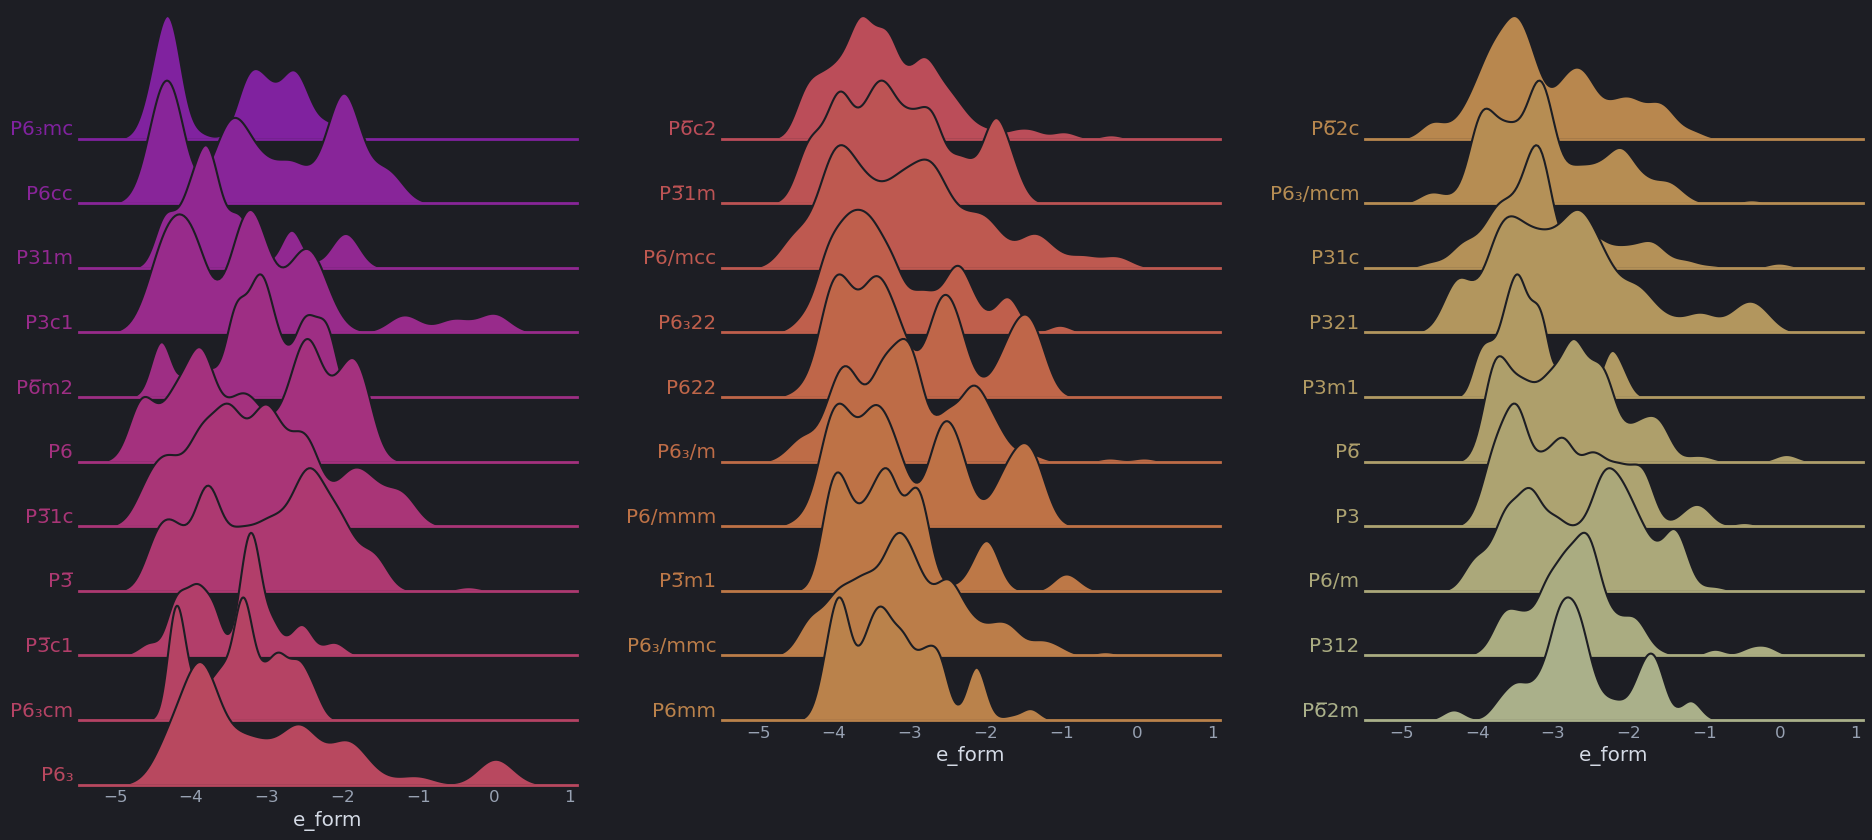

In [3]:
from baysic.viz import ridge_plot

ridge_plot(df.query('comp == "La2Pm6" and (lattice_type == "hexagonal")'), 'group_symbol', 'e_form', height=5)

In [4]:
import torch
def make_Xy(df):
    X = torch.tensor(np.hstack([
        df[['comp']].rank(method='dense').astype(int),
        df[['group_num']].rank(method='dense').astype(int),
    ])).long()
    y = torch.tensor(df['e_form'].values).float()

    return (X, y,
    sorted(set(df['comp'])),
    sorted(set(df['group_symbol'])))

test_comps = sorted([
    'La2Pm6', 'La2Tb6', 'Pb8Rh4', 'La10Pb6Zn2'
])
small_df = df[(df['comp'].str.contains('O'))]
X, y, comps, groups = make_Xy(small_df)

scaler = torch.distributions.transforms.AffineTransform(-y.mean() / y.std(), 1 / y.std())
y_scaled = scaler(y)
print(len(set(X[:, 0].cpu().numpy())), 'comps')
print(len(set(X[:, 1].cpu().numpy())), 'groups')
print(X[::len(X)//5])
X.shape, y.shape

88 comps
212 groups
tensor([[ 17, 121],
        [ 24,  86],
        [ 78, 143],
        [ 53,  34],
        [ 55,   6]])


(torch.Size([1358880, 2]), torch.Size([1358880]))

In [5]:
import torch
from torch import nn, optim, utils
from pyro import distributions as dist
from torch.nn import functional as F
import lightning.pytorch as pl

In [6]:
class EFormData(utils.data.Dataset):
    def __init__(self, X, y, comps, groups):
        self.X = X
        self.y = y
        self.comps = comps
        self.groups = groups

    def __len__(self):
        return X.size(0)

    def __getitem__(self, index):
        return self.X[index], self.y[index]


class EFormDataModule(pl.LightningDataModule):
    def __init__(self, dataset, batch_size: int = 4096, train_pct: float = 0.9):
        super().__init__()
        self.batch_size = batch_size
        self.train_pct = train_pct
        self.dataset = dataset
        train_size = int(len(dataset) * self.train_pct)
        valid_size = len(dataset) - train_size
        self.train_set, self.valid_set = utils.data.random_split(dataset, [train_size, valid_size])

    def train_dataloader(self):
        return utils.data.DataLoader(self.train_set, batch_size=self.batch_size)

    def val_dataloader(self):
        return utils.data.DataLoader(self.valid_set, batch_size=self.batch_size)

dataset = EFormData(X, y, comps, groups)
datamod = EFormDataModule(dataset)

In [27]:
simplex_transform = dist.transforms.transform_to(dist.constraints.simplex)

class BaysicModel(pl.LightningModule):
    def __init__(self, num_comps, num_groups, num_clusters: int = 3, latent_dim: int = 32, lr: float = 1e-3):
        super().__init__()
        CL, L, G, CO = num_clusters, latent_dim, num_groups + 1, num_comps
        self.lr = lr
        self.num_clusters = num_clusters
        self.num_groups = num_groups
        self.num_comps = num_comps
        self.latent_dim = latent_dim
        self.e_form_model = nn.Sequential(
            nn.Linear(2 * L, 128),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(128, 1)
        )

        self.register_buffer('alpha', 0.6 ** torch.arange(CL))
        # self.cluster_prior = dist.Dirichlet(self.alpha)
        self.register_buffer('group_prior_var', dist.Chi2(self.latent_dim).mean * 2)
        self.group_mu_prior = dist.Normal(0, self.group_prior_var)
        self.cluster_w = nn.Parameter(simplex_transform.inv(self.alpha / self.alpha.sum()).detach().broadcast_to(G, CL))
        self.group_mu = nn.Parameter(dist.MultivariateNormal(torch.zeros(L), torch.eye(L)).sample((self.num_groups + 1, self.num_clusters)))
        self.comp_mu = nn.Parameter(torch.randn((self.num_comps + 1, self.latent_dim)))

    # def init_tensors(self):
    #     self.alpha = 0.6 ** torch.arange(CL, device=dev)
    #     self.cluster_prior = dist.Dirichlet(self.alpha)
    #     self.group_mu_prior = dist.Normal(0, dist.Chi2(self.latent_dim).mean * 2)
    #     self.cluster_w = nn.Parameter((self.alpha / self.alpha.sum()).detach().broadcast_to(G, CL))
    #     self.group_mu = nn.Parameter(dist.MultivariateNormal(torch.zeros(L, device=dev), torch.eye(L, device=dev)).sample((self.num_groups + 1, self.num_clusters)))
    #     self.comp_mu = nn.Parameter(torch.randn((self.num_comps + 1, self.latent_dim), device=self.device))

    # def init_on_device(self):
    #     # now we know what device everything is on
    #     if hasattr(self, 'group_mu'):
    #         # already initialized
    #         return
    #     dev = self.device
    #     CL, L, G, CO = self.num_clusters, self.latent_dim, self.num_groups + 1, self.num_comps



    # def on_fit_start(self):
    #     self.init_on_device()

    # def on_validation_start(self):
    #     self.init_on_device()

    # def on_test_start(self):
    #     self.init_on_device()

    def predict(self, x):
        comp, group = x.swapaxes(0, -1)
        mu_x, mu_y = self.comp_mu[comp], self.group_mu[group]
        clust_w = self.cluster_w[group].swapaxes(0, 1)

        e_form = self.e_form_model(torch.cat([
            mu_x.broadcast_to(self.num_clusters, -1, self.latent_dim),
            mu_y.swapaxes(0, 1)], dim=-1)).squeeze()

        return e_form

    def step(self, batch, batch_idx):
        x, y = batch
        comp, group = x.swapaxes(0, -1)
        mu_x, mu_y = self.comp_mu[comp], self.group_mu[group]
        clust_w = simplex_transform(self.cluster_w)[group].swapaxes(0, 1)

        e_form = self.predict(x)

        log_prob = torch.logsumexp(
            dist.Normal(e_form, 2.0).log_prob(y.broadcast_to(self.num_clusters, -1)) +
            torch.log(clust_w), dim=-2).mean()

        # regularization
        group_reg = self.group_mu_prior.log_prob(torch.linalg.vector_norm(mu_x, dim=-1))
        # shouldn't affect anything, but we can add something here to keep it consistent across
        # latent dimension sizes
        group_reg = group_reg - self.group_mu_prior.log_prob(torch.zeros_like(group_reg))
        # print(cluster_reg, log_prob)
        loss = -(log_prob)
        return loss

    def training_step(self, batch, batch_idx):
        loss = self.step(batch, batch_idx)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        loss = self.step(batch, batch_idx)
        self.log('valid_loss', loss)
        return loss

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=self.lr)
        return optimizer

batch_idx = torch.arange(15)
batch = utils.data.default_collate([dataset[i] for i in batch_idx])
model = BaysicModel(len(comps), len(groups))
# model.init_on_device()
print(model.training_step(batch, batch_idx))

max_shape_len = max([t.ndim for n, t in model.named_parameters()])
for n, t in model.named_parameters():
    n_pad = max_shape_len - t.ndim
    print(f'{n:>30}', ' '.join([f'{s:>4}' for s in [''] * n_pad + list(t.shape)]))

tensor(4.4268, grad_fn=<NegBackward0>)
                     cluster_w       213    3
                      group_mu  213    3   32
                       comp_mu        89   32
         e_form_model.0.weight       128   64
           e_form_model.0.bias            128
         e_form_model.3.weight       128  128
           e_form_model.3.bias            128
         e_form_model.6.weight         1  128
           e_form_model.6.bias              1


In [28]:
trainer = pl.Trainer(
    max_epochs=100,
    logger=pl.loggers.TensorBoardLogger('.logs/'),
    callbacks=[
        pl.callbacks.DeviceStatsMonitor(cpu_stats=True),
        pl.callbacks.LearningRateFinder(),
    ]
)

trainer.fit(model, datamod)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.01
Restoring states from the checkpoint path at /home/nicholas/Dropbox/programs/baysic/.lr_find_357f5a66-cf57-4a93-ba89-5b5381b1f0fb.ckpt
Restored all states from the checkpoint at /home/nicholas/Dropbox/programs/baysic/.lr_find_357f5a66-cf57-4a93-ba89-5b5381b1f0fb.ckpt

  | Name         | Type       | Params
--------------------------------------------
0 | e_form_model | Sequential | 25.0 K
  | other params | n/a        | 23.9 K
--------------------------------------------
48.9 K    Trainable params
0         Non-trainable params
48.9 K    Total params
0.196     Total estimated model params size (MB)
Restored all states from the checkpoint at /home/nicholas/Dropbox/programs/baysic/.lr_find_357f5a66-cf57-4a93-ba89-5b5381b1f0fb.ckpt


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


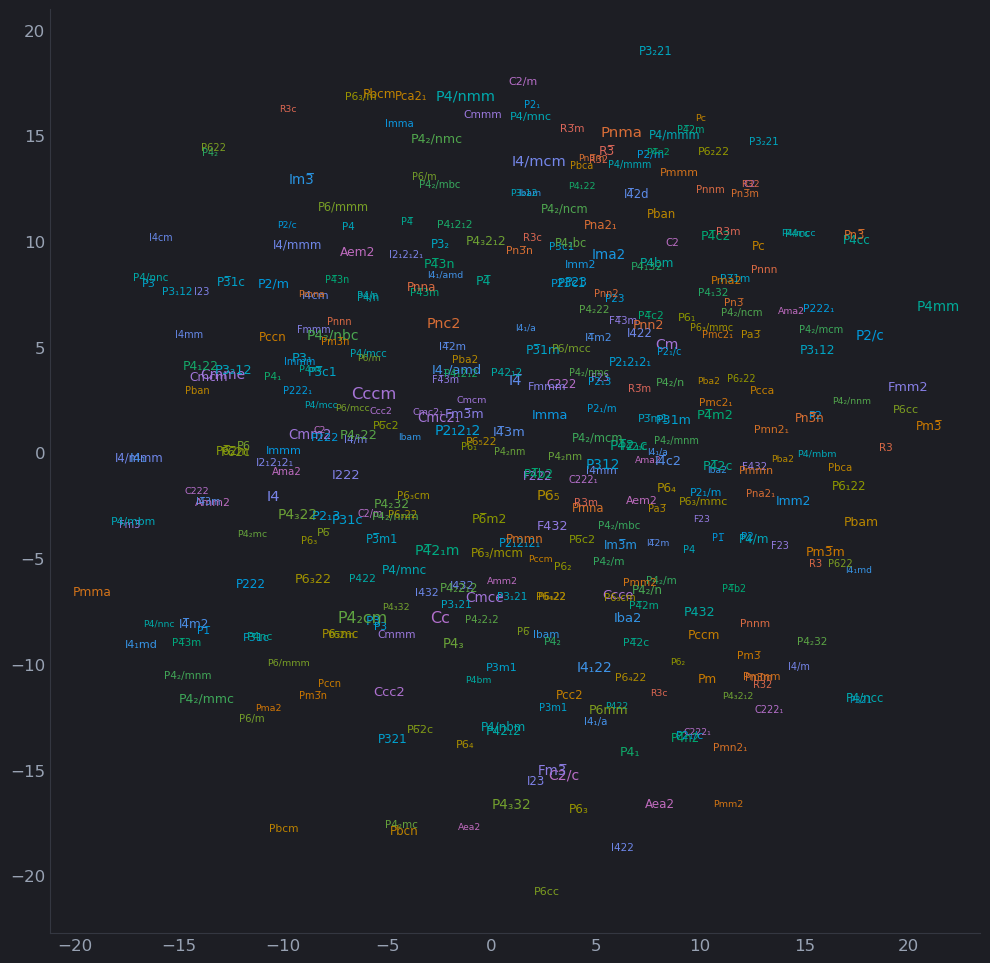

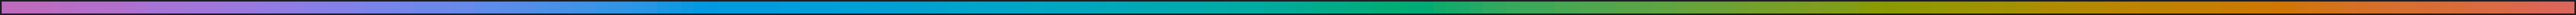

In [29]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

fig, ax = plt.subplots(figsize=(12, 12))

clust_w = simplex_transform(model.cluster_w).detach().cpu().numpy()
mus = model.group_mu.detach().cpu().numpy()
num_comps, num_clust, num_latent = mus.shape
mu_xy = TSNE(2).fit_transform(mus.reshape(-1, num_latent)).reshape(num_comps, num_clust, 2)
group_colors = sns.color_palette('rho_iso_spectra', len(groups))

for group, group_xys, color, w in zip(groups, mu_xy, group_colors, clust_w):
    for weight, group_xy in zip(w, group_xys):
        if weight > 0.3:
            ax.scatter(*group_xy, s=0)
            size = 12 * weight ** (1/2)
            ax.text(*group_xy, group, fontdict=dict(color=color, size=size), ha='center', va='center')

sns.palplot(group_colors)

In [30]:
def group_predict(comp_i):
    test_x = torch.cartesian_prod(
        torch.tensor([comp_i]),
        torch.unique(X[:, 1])
    )
    return scaler.inv(model.predict(test_x)).detach().cpu().numpy()

group_predict(4).shape

(3, 212)

In [31]:
pred_df = np.array([group_predict(c_i) for c_i in torch.unique(X[:, 0])])
pred_df.shape

(88, 3, 212)

In [32]:
from pyxtal import Group
idx = pd.MultiIndex.from_product([comps, ['A', 'B', 'C']], names=['comp', 'cluster'])

pdf = pd.DataFrame(pred_df.reshape(-1, pred_df.shape[-1]), idx, groups).reset_index().melt(id_vars=['comp', 'cluster'], var_name='group', value_name='e_form')
pdf

,comp,cluster,group,e_form
0,Ag4O8Pb4,A,Aea2,-6.163031
1,Ag4O8Pb4,B,Aea2,-6.363822
2,Ag4O8Pb4,C,Aea2,8.162969
3,Al4Ca2O8,A,Aea2,-10.506185
4,Al4Ca2O8,B,Aea2,-10.676552
...,...,...,...,...
55963,O9Rb1W3,B,R3̅m,-17.660460
55964,O9Rb1W3,C,R3̅m,-17.812880
55965,Os4Pm8Zn4,A,R3̅m,-14.783401
55966,Os4Pm8Zn4,B,R3̅m,-14.238623


In [33]:
from baysic.utils import to_pretty_name
lattice_types = [Group(g).lattice_type for g in range(1, 231)]
symbols = to_pretty_name(np.arange(1, 231))
symbol_to_type = {k: v for k, v in zip(symbols, lattice_types)}
pdf['lattice_type'] = [symbol_to_type[g] for g in pdf['group']]
pdf

,comp,cluster,group,e_form,lattice_type
0,Ag4O8Pb4,A,Aea2,-6.163031,orthorhombic
1,Ag4O8Pb4,B,Aea2,-6.363822,orthorhombic
2,Ag4O8Pb4,C,Aea2,8.162969,orthorhombic
3,Al4Ca2O8,A,Aea2,-10.506185,orthorhombic
4,Al4Ca2O8,B,Aea2,-10.676552,orthorhombic
...,...,...,...,...,...
55963,O9Rb1W3,B,R3̅m,-17.660460,hexagonal
55964,O9Rb1W3,C,R3̅m,-17.812880,hexagonal
55965,Os4Pm8Zn4,A,R3̅m,-14.783401,hexagonal
55966,Os4Pm8Zn4,B,R3̅m,-14.238623,hexagonal


/tmp/ipykernel_2433926/2104803309.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_data['group'] = actual_data['group_symbol'].astype(str)


ValueError: 'R3̅c' is not in list

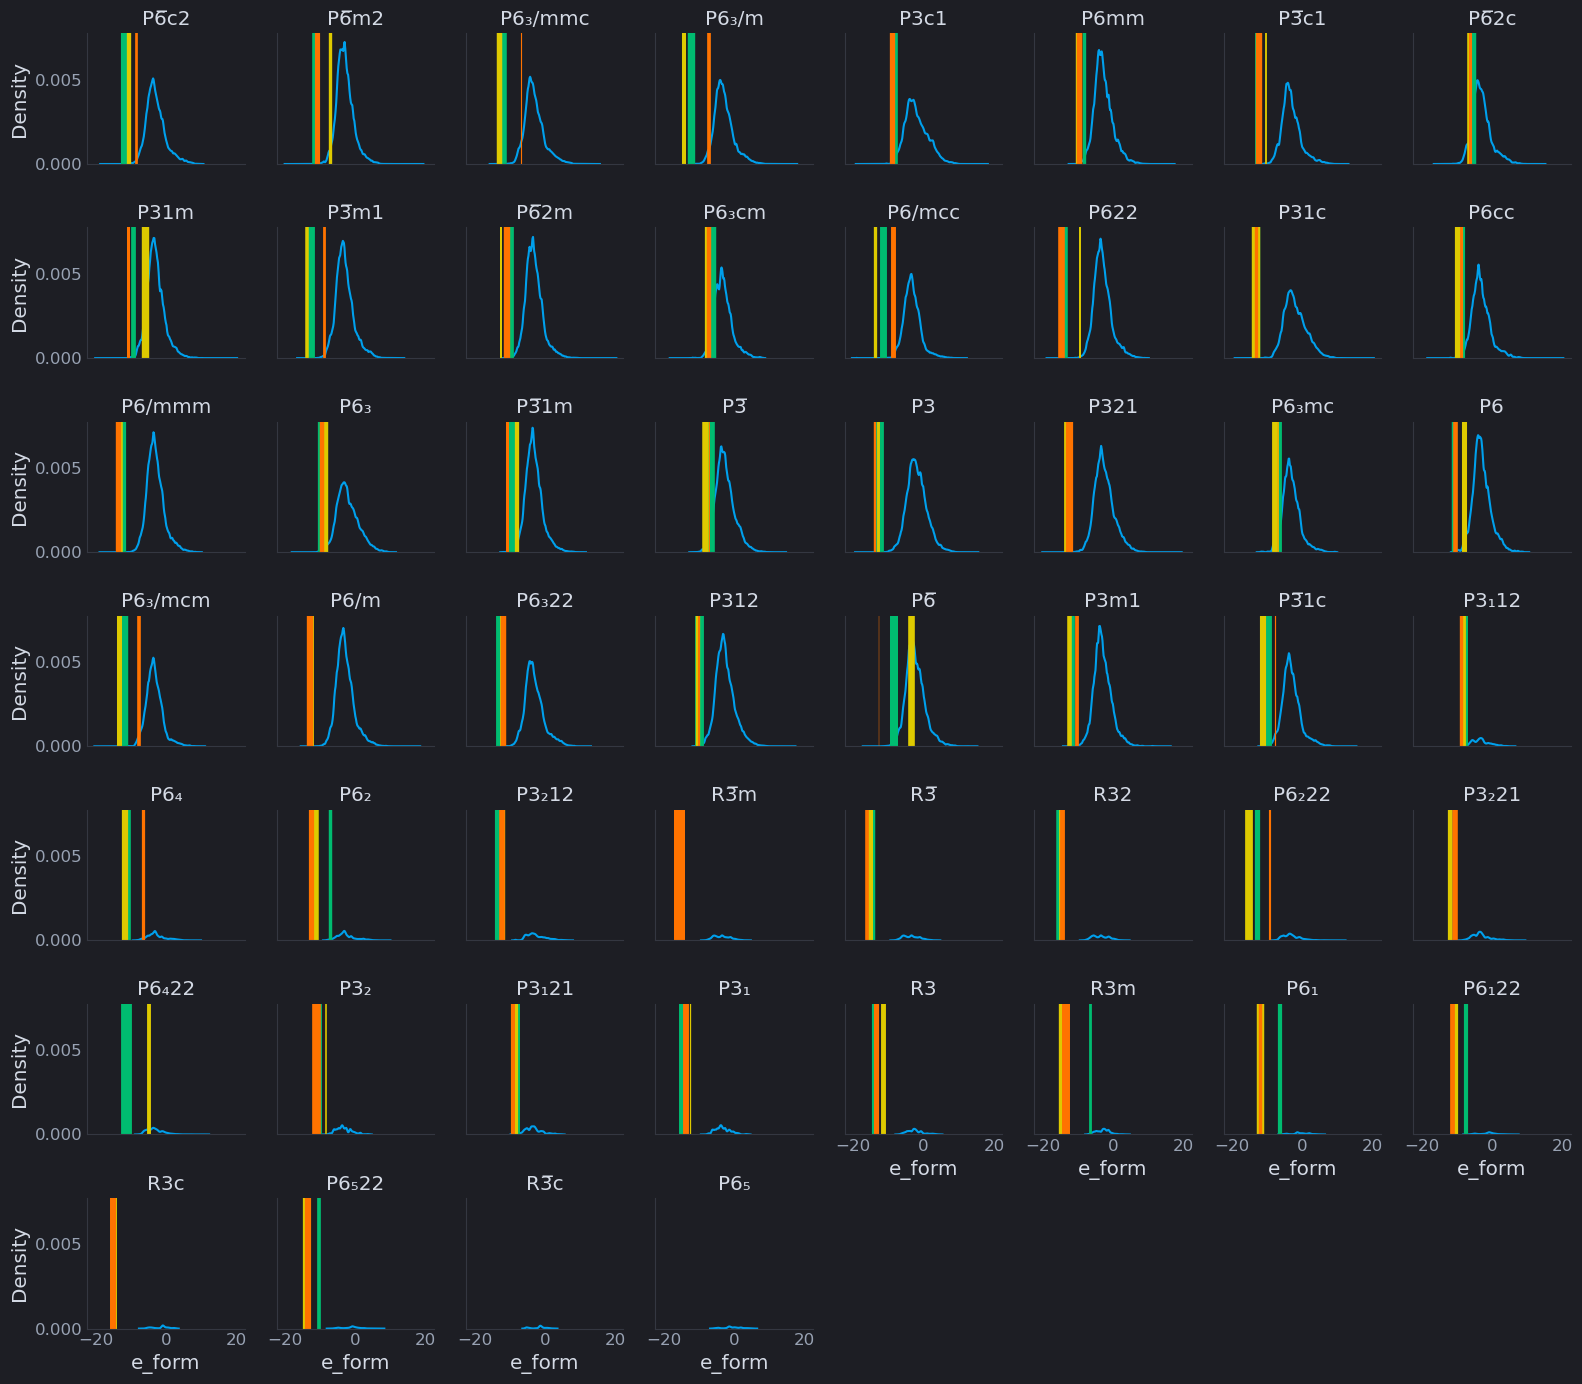

In [36]:
query = 'lattice_type == "hexagonal" and abs(e_form) < 20 '
actual_data = df.query(query)
actual_data['group'] = actual_data['group_symbol'].astype(str)
actual_groups = actual_data['group_symbol'].unique()

pdf_data = pdf.query(query + ' and group in @actual_groups')

g = sns.displot(
    actual_data,
    x='e_form',
    col='group',
    col_wrap=8,
    height=2,
    aspect=1,
    kind='kde',
    bw_adjust=0.5,
    lw=1.5
)

g.set_titles(template='{col_name}')


def add_hist(data, **kwargs):
    group = data['group'].values[0]
    subset = pdf_data.query('group == @group')
    ax = plt.gca()
    weights = clust_w[groups.index(group) + 1]
    if len(subset):
        for clust, w, color in zip('ABC', weights, cs[1:]):
            x = subset.query('cluster == @clust')['e_form'].mean()
            lo, hi = ax.get_xlim()
            if lo <= x <= hi:
                ax.axvline(x, color=color, label=clust, lw=0.3 + 10 * w)


g.map_dataframe(add_hist)
g.add_legend()

In [ ]:
ridge_plot(pdf.query('lattice_type == "hexagonal" and comp == "Ag4O8Pb4"'), 'group', 'e_form', hue='cluster')

In [ ]:
preds = pdf.groupby(['index', 'lattice_type']).min('e_form').unstack(level=1)
preds.columns = preds.columns.droplevel(0)
preds.idxmin(axis=1)

In [ ]:
from pyxtal import Group

df_valid = pd.read_feather('system_prediction.feather')

comps = pd.Series(comps)
y_system = df_valid.loc[comps[comps.isin(df_valid.index)].values, 'target']

In [ ]:
import seaborn as sns

palette = sns.color_palette('dark:#730aff', as_cmap=True)
preds = preds.loc[y_system.index].idxmin(axis=1)
use_resample=False
import sklearn.metrics as metrics



sample_weight = 1 / y_system.value_counts().loc[y_system] if use_resample else np.ones_like(y_system)
sample_weight /= np.sum(sample_weight)

order = ['triclinic', 'monoclinic', 'orthorhombic', 'tetragonal', 'hexagonal', 'cubic']
conf_mat = metrics.confusion_matrix(y_system, preds, labels=order, normalize='true').astype(float)
sns.heatmap(conf_mat, annot=True, xticklabels=order, yticklabels=order, cmap=palette, fmt='.0%')
plt.title('\n'.join([
    'MCC: {:.3f}'.format(metrics.matthews_corrcoef(y_system, preds, sample_weight=sample_weight)),
    'F1: {:.3f}'.format(metrics.f1_score(y_system, preds, average='weighted')),
    'Accuracy: {:.3f}'.format(metrics.accuracy_score(y_system, preds, sample_weight=sample_weight))
]))